In [3]:
%matplotlib inline

import argparse
import datetime
import json
import logging
import math
import os
import pickle
import time
from typing import Any, Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse as sparse
import torch
import torch.nn as nn
from torch.optim import Adam

U narednoj ćeliji se nalaze pomoćne funkcije i parametri koji će biti korišćeni u nastavku.

In [4]:
CORA_PARAMS = {
    "train_range": [0, 140],
    "val_range": [140, 640],
    "test_range": [1708, 2708],
    "num_features": 1433,
    "num_classes": 7
}


def generate_unique_name() -> str:
    """Generates (unique) name that is used for naming local runs.

    Returns:
        run_name (str): unique name.
    """
    run_name = datetime.datetime.utcnow().strftime("%y-%m-%d-%H-%M-%S-%f")

    return run_name


def make_dir_hierarchy() -> Dict[str, str]:
    """Creating all necessary directories that the current run will use.

    Returns:
        paths (argparse.Namespace): dictionary with created paths and other information.
    """
    run_name = generate_unique_name()

    # directory for storing information of current run
    runs_path = os.path.join("logs", run_name)
    os.makedirs(runs_path, exist_ok=True)

    # directory for storing log (including loss information)
    log_path = os.path.join(runs_path, "log")
    os.makedirs(log_path, exist_ok=True)

    # directory for storing checkpoints
    checkpoints_path = os.path.join(runs_path, "checkpoints")
    os.makedirs(checkpoints_path, exist_ok=True)

    paths = {
        "run_name": run_name,
        "runs_path": runs_path,
        "log_path": log_path,
        "checkpoints_path": checkpoints_path
    }

    return paths


def load_train_config(path: str) -> Dict[str, Any]:
    """Reads JSON config file and returns it.

    Args:
        path (str): config path.

    Returns:
        config (dict): config.
    """
    with open(path, "r") as f:
        config = json.load(f)

    return config


def read_from_binary(path: str):
    """Reads data from binary file.

    Args:
        path (str): path of the binary file.
    """
    with open(path, "rb") as f:
        data = pickle.load(f)

    return data


def normalize_features(features: Union[np.ndarray, sparse.csr.csr_matrix]):
    """Normalize each row to the unit row.

    Args:
        node_features (union): matrix of node features.

    Returns:
        node_features_normalized (union): normalized node features.
    """
    features_sum = np.array(np.sum(features, axis=1))

    features_inv_sum = np.squeeze(1.0 / features_sum)
    features_inv_sum[np.isinf(features_inv_sum)] = 1

    features_inv_sum_diag = sparse.diags(features_inv_sum)
    features_normalized = features_inv_sum_diag.dot(features)

    return features_normalized


def load_cora(data_dir: str, topology_normalization: str = None):
    """Loads CORA dataset.

    Args:
        data_dir (str): data directory.
        topology_normalization (str): how to normalize topology.

    Returns:
        node_features, node_labels, topology (tuple): pre-processed data.
    """
    # reading raw data
    node_features = read_from_binary(os.path.join(data_dir, "node_features.csr"))
    node_labels = read_from_binary(os.path.join(data_dir, "node_labels.npy"))
    adjacency_list = read_from_binary(os.path.join(data_dir, "adjacency_list.dict"))

    node_features = normalize_features(node_features)

    # making dense adjacency matrix ready for softmax to be applied
    topology = nx.adjacency_matrix(nx.from_dict_of_lists(adjacency_list))
    topology = topology.todense().astype(np.float32)
    # adding loops
    topology += np.identity(topology.shape[0])

    if topology_normalization == "softmax":
        # making topology ready for softmax (-np.inf -> 0; 0 -> 1)
        topology[topology == 0] = -np.inf
        topology[topology == 1] = 0
    elif topology_normalization == "unit":
        topology = normalize_features(topology)

    return node_features, node_labels, topology


def calc_accuracy(preds: torch.Tensor, labels: torch.Tensor) -> float:
    if len(preds.size()) == 2:
        preds = torch.argmax(preds, dim=1)
    elif len(preds.size()) > 2:
        raise RuntimeError("Invalid prediction shape")

    num_hits = torch.sum(preds == labels)
    accuracy = num_hits / labels.size(0)

    return accuracy

In [5]:
class DropoutWrapper(nn.Module):
    def __init__(self, fn: nn.Module, dropout_prob: float):
        super().__init__()

        self._fn = fn
        self._activation = nn.ReLU()
        self._dropout = nn.Dropout(dropout_prob)

    def forward(self, data):
        topology = data[1]
        output = self._fn(data)[0]
        output = self._dropout(self._activation(output))

        return output, topology


class GraphConvolution(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias=True):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter("bias", None)

        self._init_params()

    def _init_params(self):
        std = 1.0 / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-std, std)
        if self.bias is not None:
            self.bias.data.uniform_(-std, std)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        x, topology = data
        support = torch.matmul(x, self.weight)
        output = torch.matmul(topology, support)

        if self.bias is not None:
            output += self.bias

        return output, topology


class GCN(nn.Module):
    def __init__(self, num_features_per_layer: List[int], dropout_prob: float):
        super().__init__()

        layers = []
        for prev, curr in zip(num_features_per_layer[:-1: 2], num_features_per_layer[1::2]):
            layers.append(DropoutWrapper(GraphConvolution(prev, curr), dropout_prob))
        layers.append(GraphConvolution(num_features_per_layer[-2], num_features_per_layer[-1]))

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]):
        output = self._net(data)

        return output

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, intermediate_dim: List[int], output_dim: int):
        super().__init__()

        layers = []
        if len(intermediate_dim) == 0:
            layers.append(nn.Linear(input_dim, output_dim))
        else:
            num_neurons = [input_dim] + intermediate_dim
            for prev, curr in zip(num_neurons[:-1], num_neurons[1:]):
                layers.append(nn.Linear(prev, curr))
                layers.append(nn.GELU())

            layers.append(nn.Linear(num_neurons[-1], output_dim))

        self._net = nn.Sequential(*layers)
        self._softmax = nn.Softmax(dim=-1)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        x, topology = data
        output = self._net(x)
        output = self._softmax(output)

        return output, topology

In [7]:
class GATLayer(nn.Module):
    """Class for GAT's elementary layer."""

    def __init__(self, num_in_features: int, num_out_features: int, num_heads: int, dropout_prob: float = 0.6,
                 to_aggregate_heads: bool = False, add_skip_connection: bool = True):
        """Constructor of GAT layer.

        Args:
            num_in_features (int): number of input features.
            num_out_features (int): number of output features.
            num_heads (int): number of attention heads.
            dropout_prob (float): probability of dropout.
            to_aggregate_heads (bool): aggregate features of attention heads (True) or not (False).
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        # head's dimension
        self._head_dim = 1
        self._num_in_features = num_in_features
        self._num_out_features = num_out_features
        self._num_heads = num_heads
        self._to_aggregate_heads = to_aggregate_heads
        self._add_skip_connection = add_skip_connection

        # not used during training - only for logging/visualization
        self._attention_weights = None

        # projection and scoring mappings
        self._proj_param = nn.Parameter(torch.Tensor(num_heads, num_in_features, num_out_features))
        self._scoring_source = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))
        self._scoring_target = nn.Parameter(torch.Tensor(num_heads, num_out_features, 1))

        if add_skip_connection:
            self._skip_proj = nn.Linear(num_in_features, num_heads * num_out_features, bias=False)

        self._activation = nn.LeakyReLU(negative_slope=0.2)
        self._softmax = nn.Softmax(dim=-1)
        self._dropout = nn.Dropout(p=dropout_prob)

        self._init_params()

    def _init_params(self):
        nn.init.xavier_uniform_(self._proj_param)
        nn.init.xavier_uniform_(self._scoring_source)
        nn.init.xavier_uniform_(self._scoring_target)

    def _aggregate_heads(self, attention_weights: torch.Tensor, in_node_features: torch.Tensor, out_node_features: torch.Tensor) \
            -> torch.Tensor:
        """Aggregate features of all attention heads.

        Aggregation is either cocatenation or mean.

        Args:
            attention_weights (torch.Tensor): attention coefficients.
            in_node_features (torch.Tensor): input node features.
            out_node_features (torch.Tensor): output node features.

        Returns:
            out_node_features (torch.Tensor): aggregated node features.
        """
        # for later inspection
        self._attention_weights = attention_weights

        # view will raise an exception if underlying memory isn't contiguous
        if not out_node_features.is_contiguous():
            out_node_features = out_node_features.contiguous()

        if self._add_skip_connection:
            if out_node_features.size(-1) == in_node_features.size(-1):
                out_node_features += in_node_features.unsqueeze(1)
            else:
                out_node_features += self._skip_proj(in_node_features).view(-1, self._num_heads, self._num_out_features)

        if self._to_aggregate_heads:
            out_node_features = out_node_features.view(-1, self._num_heads * self._num_out_features)
        else:
            out_node_features = torch.mean(out_node_features, dim=self._head_dim)

        out_node_features = self._activation(out_node_features)

        return out_node_features

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            out_node_features, topology (tuple): output node features and graph topology.
        """
        in_node_features, topology = data
        num_nodes = in_node_features.shape[0]
        assert topology.shape == (num_nodes, num_nodes), "Adjacency matrix has invalid shape."

        in_node_features = self._dropout(in_node_features)
        node_features_proj = torch.matmul(in_node_features.unsqueeze(0), self._proj_param)
        node_features_proj = self._dropout(node_features_proj)

        edge_scores_source = torch.bmm(node_features_proj, self._scoring_source)
        edge_scores_target = torch.bmm(node_features_proj, self._scoring_target)
        edge_scores = self._activation(edge_scores_source + edge_scores_target.transpose(1, 2))
        attention_weights = self._softmax(edge_scores + topology)

        out_node_features = torch.bmm(attention_weights, node_features_proj)
        out_node_features = out_node_features.transpose(0, 1)

        out_node_features = self._aggregate_heads(attention_weights, in_node_features, out_node_features)

        return out_node_features, topology


class GAT(nn.Module):
    """Class for Graph Attention Network (GAT)."""

    def __init__(self, num_heads_per_layer: List[int], num_features_per_layer: List[int], dropout_prob: float = 0.6,
                 add_skip_connection: bool = True, **kwargs):
        """Constructor of GAT.

        Args:
            num_heads_per_layer (list): number of heads for each layer.
            num_features_per_layer (list): number of features for each layer.
            dropout_prob (float): probability of dropout layer used in GAT's layers.
            add_skip_connection (bool): to add (True) or not (False) residual/skip connection.
        """
        super().__init__()

        num_layers = len(num_heads_per_layer)
        num_heads_per_layer = [1] + num_heads_per_layer

        layers = []
        for i in range(num_layers):
            layer = GATLayer(num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],
                             num_out_features=num_features_per_layer[i + 1],
                             num_heads=num_heads_per_layer[i + 1],
                             to_aggregate_heads=i < num_layers - 1,
                             dropout_prob=dropout_prob,
                             add_skip_connection=add_skip_connection)
            layers.append(layer)

        self._net = nn.Sequential(*layers)

    def forward(self, data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass.

        Input needs to be fed as a tuple because GAT is defined as a sequential model.

        Args:
            data (tuple): input node features and graph topology.

        Returns:
            output (tuple): output node features and graph topology.
        """
        output = self._net(data)

        return output

Predstoji klasa namenjena enkapsulaciji treninga. Kreiraće model na osnovu prosleđene konfiguracije i vršiti detaljni prikaz rezultata (funkcije gubitka i tačnosti).

In [8]:
class Trainer:
    """Class used for training the GAT."""

    def __init__(self, config: Dict[str, Any]):
        """Constructor.

        Args:
            config (dict): configuration of the training, inference and the model.
        """
        self._paths = make_dir_hierarchy()
        self._setup_logger(os.path.join(self._paths["log_path"], "log.txt"))

        with open(os.path.join(self._paths["runs_path"], "config.json"), "w") as f:
            json.dump(config, f, indent=4)

        self._config = config
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        topology_normalization = "unit" if config["model_name"] == "GCN" else "softmax"
        node_features, node_labels, topology = load_cora(config["data_dir"], topology_normalization)
        self._node_features = torch.tensor(node_features.todense(), device=self._device)
        self._node_labels = torch.tensor(node_labels, dtype=torch.long, device=self._device)
        self._topology = torch.tensor(topology, dtype=torch.float32, device=self._device)
        self._indices = {
            "train": torch.arange(*CORA_PARAMS["train_range"], dtype=torch.long, device=self._device),
            "val": torch.arange(*CORA_PARAMS["val_range"], dtype=torch.long, device=self._device),
            "test": torch.arange(*CORA_PARAMS["test_range"], dtype=torch.long, device=self._device)
        }

        if config["model_name"] == "GCN":
            self._model = GCN(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "GAT":
            self._model = GAT(**config["model_kwargs"]).to(self._device)
        elif config["model_name"] == "MLP":
            self._model = MLP(**config["model_kwargs"]).to(self._device)

        self._criterion = nn.CrossEntropyLoss()
        self._optimizer = Adam(self._model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

        # saves all metrics and losses during training
        self._aggregator = {}

    def _update_aggregator(self, name: str, value: float) -> None:
        aggregated_values = self._aggregator.get(name, [])
        aggregated_values.append(value)
        self._aggregator[name] = aggregated_values

    def _setup_logger(self, log_path: str) -> None:
        """Setup logging to print logs to both file and stdout.

        Timestamps are in GMT format due to lexicographic order. Example: 22-01-27-21-09-48.

        Args:
            log_path (str): path of log file.
        """
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s: [%(levelname)s] %(message)s",
            datefmt="%y-%m-%d %H:%M:%S",
            handlers=[
                logging.FileHandler(log_path),
                logging.StreamHandler()
            ]
        )
        logging.Formatter.converter = time.gmtime

    def _prepare_log(self, epoch, ce, acc, name):
        epoch_length = len(str(self._config["epochs"]))
        total_length = len(f"epoch=[{self._config['epochs']}/{self._config['epochs']}]:")
        epoch_log = f"epoch=[{epoch:>{epoch_length}}/{self._config['epochs']}]:"
        ce_log = f"CE_{name}={ce:.5f}"
        acc_log = f"ACC_{name}={acc:.2%}"
        log = f"{epoch_log:<{total_length}} {ce_log:>16} {acc_log:>16}"

        return log

    def run_training(self):
        train_labels = self._node_labels.index_select(0, self._indices["train"])
        train_indices = self._indices["train"]
        graph_data = (self._node_features, self._topology)

        for epoch in range(1, self._config["epochs"] + 1):
            self._model.train()
            self._optimizer.zero_grad()

            pred_labels = self._model(graph_data)[0].index_select(0, train_indices)
            loss = self._criterion(pred_labels, train_labels)
            accuracy = calc_accuracy(pred_labels, train_labels)

            logging.info(self._prepare_log(epoch, loss.item(), accuracy, "train"))
            self._update_aggregator("CE_train", (epoch, loss.item()))
            self._update_aggregator("ACC_train", (epoch, accuracy))

            loss.backward()
            self._optimizer.step()

            if epoch % self._config["ckpt_freq"] == 0:
                self._dump_model(epoch)

            if epoch == 1 or epoch % self._config["val_freq"] == 0:
                self._run_val(epoch)

            if epoch == 1 or epoch % self._config["test_freq"] == 0:
                self._run_test(epoch)

    def _run_val(self, epoch: int):
        val_labels = self._node_labels.index_select(0, self._indices["val"])
        val_indices = self._indices["val"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, val_indices)
        loss = self._criterion(pred_labels, val_labels)
        accuracy = calc_accuracy(pred_labels, val_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "val"))
        self._update_aggregator("CE_val", (epoch, loss.item()))
        self._update_aggregator("ACC_val", (epoch, accuracy))

    def _run_test(self, epoch: int):
        test_labels = self._node_labels.index_select(0, self._indices["test"])
        test_indices = self._indices["test"]
        graph_data = (self._node_features, self._topology)

        self._model.eval()
        pred_labels = self._model(graph_data)[0].index_select(0, test_indices)
        loss = self._criterion(pred_labels, test_labels)
        accuracy = calc_accuracy(pred_labels, test_labels)

        logging.info(self._prepare_log(epoch, loss.item(), accuracy, "test"))
        self._update_aggregator("CE_test", (epoch, loss.item()))
        self._update_aggregator("ACC_test", (epoch, accuracy))

    def _dump_model(self, epoch: int) -> None:
        """Dumps current checkpoint.

        Args:
            epoch (int): current epoch.
        """
        ckpt_path = os.path.join(self._paths["checkpoints_path"], f"gat_{epoch}.ckpt")
        torch.save(self._model.state_dict(), ckpt_path)

    @property
    def aggregator(self) -> Dict[str, Any]:
        """Getter for aggregator."""
        return self._aggregator

    @property
    def model(self) -> nn.Module:
        """Getter for model."""
        return self._model

    @property
    def device(self) -> torch.device:
        """Getter for device."""
        return self._device

# Treniranje modela

Obučićemo prethodno definisane modele i potom ih analizirati. U pitanju su višelojni perceptron, grafovska konvolutivna mreža i grafovska mreža sa mehanizmom pažnje.

In [9]:
config_gcn = {
    "model_name": "GCN",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_features_per_layer": [1433, 16, 7],
        "dropout_prob": 0.5
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gcn = Trainer(config_gcn)
trainer_gcn.run_training()

22-06-21 18:45:32: [INFO] epoch=[  1/200]: CE_train=1.95671 ACC_train=16.43%
22-06-21 18:45:32: [INFO] epoch=[  1/200]:   CE_val=1.92336   ACC_val=12.20%
22-06-21 18:45:32: [INFO] epoch=[  1/200]:  CE_test=1.92171  ACC_test=13.00%
22-06-21 18:45:32: [INFO] epoch=[  2/200]: CE_train=1.95983 ACC_train=15.00%
22-06-21 18:45:32: [INFO] epoch=[  3/200]: CE_train=1.95026 ACC_train=15.71%
22-06-21 18:45:32: [INFO] epoch=[  4/200]: CE_train=1.94710 ACC_train=12.86%
22-06-21 18:45:32: [INFO] epoch=[  5/200]: CE_train=1.93675 ACC_train=15.71%
22-06-21 18:45:32: [INFO] epoch=[  6/200]: CE_train=1.93347 ACC_train=17.86%
22-06-21 18:45:32: [INFO] epoch=[  7/200]: CE_train=1.93369 ACC_train=22.14%
22-06-21 18:45:32: [INFO] epoch=[  8/200]: CE_train=1.92232 ACC_train=22.86%
22-06-21 18:45:32: [INFO] epoch=[  9/200]: CE_train=1.92224 ACC_train=27.14%
22-06-21 18:45:33: [INFO] epoch=[ 10/200]: CE_train=1.91851 ACC_train=30.00%
22-06-21 18:45:33: [INFO] epoch=[ 10/200]:   CE_val=1.93729   ACC_val=31.80%

22-06-21 18:45:42: [INFO] epoch=[ 90/200]: CE_train=0.62635 ACC_train=93.57%
22-06-21 18:45:42: [INFO] epoch=[ 90/200]:   CE_val=1.04469   ACC_val=78.60%
22-06-21 18:45:42: [INFO] epoch=[ 90/200]:  CE_test=1.01217  ACC_test=81.30%
22-06-21 18:45:42: [INFO] epoch=[ 91/200]: CE_train=0.70530 ACC_train=91.43%
22-06-21 18:45:42: [INFO] epoch=[ 92/200]: CE_train=0.63570 ACC_train=95.71%
22-06-21 18:45:42: [INFO] epoch=[ 93/200]: CE_train=0.67036 ACC_train=90.00%
22-06-21 18:45:43: [INFO] epoch=[ 94/200]: CE_train=0.66157 ACC_train=91.43%
22-06-21 18:45:43: [INFO] epoch=[ 95/200]: CE_train=0.62422 ACC_train=95.00%
22-06-21 18:45:43: [INFO] epoch=[ 96/200]: CE_train=0.64661 ACC_train=92.86%
22-06-21 18:45:43: [INFO] epoch=[ 97/200]: CE_train=0.64685 ACC_train=92.14%
22-06-21 18:45:43: [INFO] epoch=[ 98/200]: CE_train=0.64268 ACC_train=90.71%
22-06-21 18:45:43: [INFO] epoch=[ 99/200]: CE_train=0.58095 ACC_train=95.00%
22-06-21 18:45:43: [INFO] epoch=[100/200]: CE_train=0.58976 ACC_train=96.43%

22-06-21 18:45:50: [INFO] epoch=[179/200]: CE_train=0.36184 ACC_train=97.14%
22-06-21 18:45:50: [INFO] epoch=[180/200]: CE_train=0.37678 ACC_train=93.57%
22-06-21 18:45:50: [INFO] epoch=[180/200]:   CE_val=0.78800   ACC_val=80.00%
22-06-21 18:45:50: [INFO] epoch=[180/200]:  CE_test=0.75007  ACC_test=80.00%
22-06-21 18:45:50: [INFO] epoch=[181/200]: CE_train=0.33175 ACC_train=99.29%
22-06-21 18:45:50: [INFO] epoch=[182/200]: CE_train=0.36827 ACC_train=95.71%
22-06-21 18:45:50: [INFO] epoch=[183/200]: CE_train=0.30521 ACC_train=97.86%
22-06-21 18:45:50: [INFO] epoch=[184/200]: CE_train=0.36298 ACC_train=96.43%
22-06-21 18:45:50: [INFO] epoch=[185/200]: CE_train=0.35611 ACC_train=97.86%
22-06-21 18:45:51: [INFO] epoch=[186/200]: CE_train=0.33867 ACC_train=97.14%
22-06-21 18:45:51: [INFO] epoch=[187/200]: CE_train=0.33398 ACC_train=96.43%
22-06-21 18:45:51: [INFO] epoch=[188/200]: CE_train=0.36533 ACC_train=97.14%
22-06-21 18:45:51: [INFO] epoch=[189/200]: CE_train=0.36793 ACC_train=95.71%

In [10]:
config_gat = {
    "model_name": "GAT",
    "data_dir": "data",
    "epochs": 200,
    "lr": 0.005,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "num_heads_per_layer": [8, 1],
        "add_skip_connection": False,
        "num_features_per_layer": [1433, 8, 7],
        "dropout_prob": 0.6
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_gat = Trainer(config_gat)
trainer_gat.run_training()

22-06-21 18:45:55: [INFO] epoch=[  1/200]: CE_train=1.94598 ACC_train=11.43%
22-06-21 18:45:59: [INFO] epoch=[  1/200]:   CE_val=1.94548   ACC_val=49.80%
22-06-21 18:46:00: [INFO] epoch=[  1/200]:  CE_test=1.94548  ACC_test=48.40%
22-06-21 18:46:02: [INFO] epoch=[  2/200]: CE_train=1.94549 ACC_train=25.71%
22-06-21 18:46:05: [INFO] epoch=[  3/200]: CE_train=1.94449 ACC_train=50.71%
22-06-21 18:46:09: [INFO] epoch=[  4/200]: CE_train=1.94324 ACC_train=50.71%
22-06-21 18:46:11: [INFO] epoch=[  5/200]: CE_train=1.94204 ACC_train=51.43%
22-06-21 18:46:15: [INFO] epoch=[  6/200]: CE_train=1.94076 ACC_train=62.14%
22-06-21 18:46:18: [INFO] epoch=[  7/200]: CE_train=1.94064 ACC_train=55.71%
22-06-21 18:46:20: [INFO] epoch=[  8/200]: CE_train=1.93800 ACC_train=55.00%
22-06-21 18:46:23: [INFO] epoch=[  9/200]: CE_train=1.93572 ACC_train=62.14%
22-06-21 18:46:26: [INFO] epoch=[ 10/200]: CE_train=1.93428 ACC_train=60.71%
22-06-21 18:46:29: [INFO] epoch=[ 10/200]:   CE_val=1.93553   ACC_val=75.40%

22-06-21 18:49:51: [INFO] epoch=[ 90/200]: CE_train=1.04065 ACC_train=77.14%
22-06-21 18:49:54: [INFO] epoch=[ 90/200]:   CE_val=1.44594   ACC_val=79.20%
22-06-21 18:49:55: [INFO] epoch=[ 90/200]:  CE_test=1.42618  ACC_test=78.30%
22-06-21 18:49:57: [INFO] epoch=[ 91/200]: CE_train=0.87216 ACC_train=77.86%
22-06-21 18:49:59: [INFO] epoch=[ 92/200]: CE_train=1.12459 ACC_train=65.71%
22-06-21 18:50:01: [INFO] epoch=[ 93/200]: CE_train=0.84333 ACC_train=79.29%
22-06-21 18:50:03: [INFO] epoch=[ 94/200]: CE_train=0.83567 ACC_train=77.86%
22-06-21 18:50:06: [INFO] epoch=[ 95/200]: CE_train=0.96299 ACC_train=71.43%
22-06-21 18:50:08: [INFO] epoch=[ 96/200]: CE_train=0.91416 ACC_train=75.00%
22-06-21 18:50:10: [INFO] epoch=[ 97/200]: CE_train=1.08070 ACC_train=67.14%
22-06-21 18:50:12: [INFO] epoch=[ 98/200]: CE_train=1.00700 ACC_train=70.71%
22-06-21 18:50:14: [INFO] epoch=[ 99/200]: CE_train=0.93232 ACC_train=75.71%
22-06-21 18:50:17: [INFO] epoch=[100/200]: CE_train=0.96777 ACC_train=67.86%

22-06-21 18:53:35: [INFO] epoch=[179/200]: CE_train=0.69877 ACC_train=78.57%
22-06-21 18:53:37: [INFO] epoch=[180/200]: CE_train=0.74376 ACC_train=77.14%
22-06-21 18:53:39: [INFO] epoch=[180/200]:   CE_val=1.29561   ACC_val=80.40%
22-06-21 18:53:40: [INFO] epoch=[180/200]:  CE_test=1.26774  ACC_test=81.40%
22-06-21 18:53:41: [INFO] epoch=[181/200]: CE_train=0.88678 ACC_train=70.00%
22-06-21 18:53:44: [INFO] epoch=[182/200]: CE_train=0.91072 ACC_train=70.71%
22-06-21 18:53:46: [INFO] epoch=[183/200]: CE_train=0.55078 ACC_train=87.14%
22-06-21 18:53:48: [INFO] epoch=[184/200]: CE_train=0.84133 ACC_train=75.71%
22-06-21 18:53:50: [INFO] epoch=[185/200]: CE_train=0.71086 ACC_train=77.86%
22-06-21 18:53:52: [INFO] epoch=[186/200]: CE_train=0.72216 ACC_train=77.14%
22-06-21 18:53:55: [INFO] epoch=[187/200]: CE_train=0.82721 ACC_train=70.00%
22-06-21 18:53:57: [INFO] epoch=[188/200]: CE_train=0.75148 ACC_train=77.14%
22-06-21 18:53:59: [INFO] epoch=[189/200]: CE_train=0.73443 ACC_train=77.86%

In [11]:
config_mlp = {
    "model_name": "MLP",
    "data_dir": "data",
    "epochs": 100,
    "lr": 0.01,
    "weight_decay": 0.0005,
    "model_kwargs": {
        "input_dim": 1433,
        "intermediate_dim": [4096],
        "output_dim": 7
    },
    "ckpt_freq": 100,
    "val_freq": 10,
    "test_freq": 10
}

trainer_mlp = Trainer(config_mlp)
trainer_mlp.run_training()

22-06-21 18:54:31: [INFO] epoch=[  1/100]: CE_train=1.94592 ACC_train=14.29%
22-06-21 18:54:32: [INFO] epoch=[  1/100]:   CE_val=1.94527   ACC_val=23.20%
22-06-21 18:54:32: [INFO] epoch=[  1/100]:  CE_test=1.94523  ACC_test=26.40%
22-06-21 18:54:33: [INFO] epoch=[  2/100]: CE_train=1.94439 ACC_train=43.57%
22-06-21 18:54:33: [INFO] epoch=[  3/100]: CE_train=1.94325 ACC_train=27.86%
22-06-21 18:54:34: [INFO] epoch=[  4/100]: CE_train=1.94033 ACC_train=20.00%
22-06-21 18:54:35: [INFO] epoch=[  5/100]: CE_train=1.93405 ACC_train=17.14%
22-06-21 18:54:36: [INFO] epoch=[  6/100]: CE_train=1.92285 ACC_train=17.14%
22-06-21 18:54:37: [INFO] epoch=[  7/100]: CE_train=1.90456 ACC_train=27.86%
22-06-21 18:54:38: [INFO] epoch=[  8/100]: CE_train=1.87882 ACC_train=36.43%
22-06-21 18:54:39: [INFO] epoch=[  9/100]: CE_train=1.84745 ACC_train=42.86%
22-06-21 18:54:40: [INFO] epoch=[ 10/100]: CE_train=1.81254 ACC_train=43.57%
22-06-21 18:54:41: [INFO] epoch=[ 10/100]:   CE_val=1.92476   ACC_val=31.40%

22-06-21 18:56:06: [INFO] epoch=[ 90/100]: CE_train=1.49962 ACC_train=71.43%
22-06-21 18:56:07: [INFO] epoch=[ 90/100]:   CE_val=1.78645   ACC_val=49.40%
22-06-21 18:56:07: [INFO] epoch=[ 90/100]:  CE_test=1.76757  ACC_test=51.70%
22-06-21 18:56:08: [INFO] epoch=[ 91/100]: CE_train=1.49930 ACC_train=71.43%
22-06-21 18:56:09: [INFO] epoch=[ 92/100]: CE_train=1.49885 ACC_train=71.43%
22-06-21 18:56:09: [INFO] epoch=[ 93/100]: CE_train=1.49879 ACC_train=71.43%
22-06-21 18:56:10: [INFO] epoch=[ 94/100]: CE_train=1.49873 ACC_train=71.43%
22-06-21 18:56:11: [INFO] epoch=[ 95/100]: CE_train=1.49835 ACC_train=71.43%
22-06-21 18:56:12: [INFO] epoch=[ 96/100]: CE_train=1.49812 ACC_train=71.43%
22-06-21 18:56:13: [INFO] epoch=[ 97/100]: CE_train=1.49822 ACC_train=71.43%
22-06-21 18:56:14: [INFO] epoch=[ 98/100]: CE_train=1.49863 ACC_train=71.43%
22-06-21 18:56:15: [INFO] epoch=[ 99/100]: CE_train=1.49877 ACC_train=71.43%
22-06-21 18:56:16: [INFO] epoch=[100/100]: CE_train=1.49959 ACC_train=71.43%

In [12]:
def plot_metrics(aggregator: Dict[str, List[Tuple[float, float]]], metric_name: str, axis):
    metric_name = metric_name.upper()
    suffixes = ["train", "val", "test"]
    colors = ["blue", "green", "red"]

    for suffix, color in zip(suffixes, colors):
        name = f"{metric_name}_{suffix}"
        metric_values = aggregator[name]
        x_coords = list(map(lambda p: p[0], metric_values))
        y_coords = list(map(lambda p: p[1], metric_values))

        axis.plot(x_coords, y_coords, label=suffix, color=color)

    axis.legend(loc="upper right")
    axis.set_title(metric_name)
    axis.grid()

Prikaz funkcije gubitka i tačnosti tokom treninga, validacije i testa.

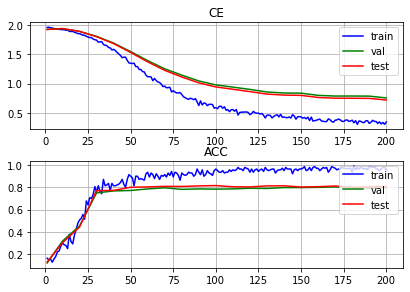

In [13]:
aggregator = trainer_gcn.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

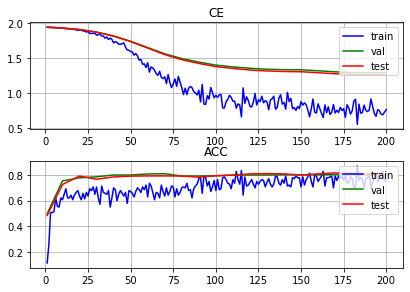

In [14]:
aggregator = trainer_gat.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

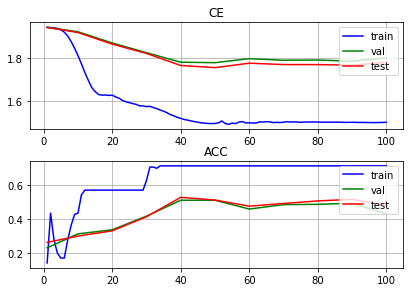

In [15]:
aggregator = trainer_mlp.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

Na osnovu prikazanih grafika i metrika, možemo primetiti da je MLP ubedljivo najlošiji. Takođe, ne postoji statistički značajna razlika između GAT-a i GCN-a. Evidentan je manji šum u treningu kod GCN-a, kao i primetno preprilagođenje.

# Topološka analiza rezultata

Nakon što smo istrenirali GAT model, možemo izvršiti različite vizualizacije iz kojih ćemo izvesti korisne zaključke.
Prikazaćemo ih ukupno tri:
1. Vizualizacija podataka u skrivenom prostoru GAT modela, koristeći t-SNE (**t-distributed Stochastic Neighbor Embedding**),
2. Vizualizacija podataka u skrivenom prostoru GAT modela, koristeći nešto noviji algoritam po imenu UMAP (**Uniform Manifold Approximation and Projection**) i
3. Vizualizacija vrednosti koeficijenata pažnje pomoću entropije, pri čemu će biti upoređeni sa ravnomernom raspodelom.

t-SNE i UMAP su algoritmi za smanjivanje dimenzija podataka koji se oslanjaju na algebarsku topologiju prilikom analize podataka, određujući utapanje koje čuva topologiju. 

U izlaznom sloju prostoru GAT modela svaki čvor ima 7 atributa (jer imamo 7 različitih klasa), pa je cilj da, koristeći t-SNE i UMAP, preslikamo prostor $\mathbb{R}^7$ u $\mathbb{R}^2$ koji značajno lakše možemo da prikažemo.

GAT model sa jednakim koeficijentima pažnje se može tumačiti kao obična konvolutivna grafovska mreža. Odnosno skup modela grafovske konvolutivne mreže se može smatrati podskupom skupa GAT modela. Zato je ideja da pomoću treće i četvrte vizualizacija uporedimo koliko se raspodela koeficijenata pažnje razlikuje od uniformne raspodele. Što se više razlikuje, to se GAT model više razlikuje od konvolutivne grafovske mreže.

In [16]:
from sklearn.manifold import TSNE
from scipy.stats import entropy
import umap.umap_ as umap

Prvo ćemo definisati pomoćnu funkciju čiji je ulaz objekat klase Trainer, a izlazne vrednosti su vrednosti atributa pre primene softmax funkcije u poslednjem skrivenom sloju, skup grana grafa, labele čvorova i GAT model.

In [17]:
def model_forward_propagation(trainer):
    device = trainer.device

    model = trainer.model
    node_features = trainer._node_features
    node_labels = trainer._node_labels
    topology = trainer._topology
    model.eval()
    
    with torch.no_grad():
        # run predictions and collect the data before softmax
        scores_before_softmax, _ = model((node_features, topology))
        scores_before_softmax = scores_before_softmax.cpu().numpy()
        
    return scores_before_softmax, topology, node_labels, model

Zatim imamo i pomoćnu funkciju za iscrtavanje histograma. Hoćemo da iscrtamo histograme za vrednosti koeficijente pažnje i za ravnomernu raspodelu, pa taj izbor pravimo pomoću parametra `uniform_distribution`.

In [18]:
def entropy_histogram(entropy_array, title, color="blue", uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f"entropy bins")
    plt.ylabel(f"Number of node neighborhoods")
    plt.title(title)

Konačno, definišemo glavnu funkciju za vizualizaciju modela. Pomoću parametra `visualization_type` biramo tip vizualizacije (t-SNE, UMAP ili entropija).

In [19]:
def visualize(trainer, visualization_type):
    scores_before_softmax, topology, node_labels, model = model_forward_propagation(trainer)
    node_labels = node_labels.cpu().numpy()
    num_classes = CORA_PARAMS["num_classes"]
    
    if visualization_type == "tsne":
        # showing t-SNE in 2D embedding space
        t_sne_embeddings = TSNE(n_components=2, perplexity=30).fit_transform(scores_before_softmax)

        fig = plt.figure(figsize=(12,8), dpi=100)  
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], 
                        t_sne_embeddings[node_labels == class_id, 1],
                        s=20, color={0: "yellow", 1: "red", 2: "green", 3: "orange",
                                     4: "pink", 5: "blue", 6: "gray"}[class_id], edgecolors='black', linewidths=0.2)
        plt.show()
    elif visualization_type == "umap":
        umap_embeddings = umap.UMAP(n_components=2).fit_transform(scores_before_softmax)

        fig = plt.figure(figsize=(12,8), dpi=100)  
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way
            plt.scatter(umap_embeddings[node_labels == class_id, 0],
                        umap_embeddings[node_labels == class_id, 1], s=20, 
                        color={0: "yellow", 1: "red", 2: "green", 3: "orange",
                               4: "pink", 5: "blue", 6: "gray"}[class_id], edgecolors='black', linewidths=0.2)
        plt.show()
    elif visualization_type == "entropy":
        num_heads_per_layer = [layer._num_heads for layer in model._net]
        num_layers = len(num_heads_per_layer)

        _, _, topology = load_cora(config_gat["data_dir"])

        num_of_nodes = len(node_labels)
        for layer_id in range(num_layers):
            all_attentions = model._net[layer_id]._attention_weights.cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                head_attentions = all_attentions[head_id]
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes):
                    # finding neighborhood of the target node
                    neighborhood = np.nonzero(topology[:, target_node_id])
                    neighborhood_attentions = head_attentions[neighborhood, target_node_id].flatten()
                    ideal_uniform_attention = np.ones(len(neighborhood_attentions)) / len(neighborhood_attentions)

                    neighborhood_entropy_list.append(entropy(neighborhood_attentions, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f"Cora entropy histogram layer={layer_id}, attention head={head_id}"
                entropy_histogram(uniform_dist_entropy_list, title, color="darkseagreen", uniform_distribution=True)
                entropy_histogram(neighborhood_entropy_list, title, color="crimson")
                plt.show()
                plt.close()

Prvo ćemo vizualizovati podatke za sva tri modela koristeći t-SNE, a zatim UMAP.

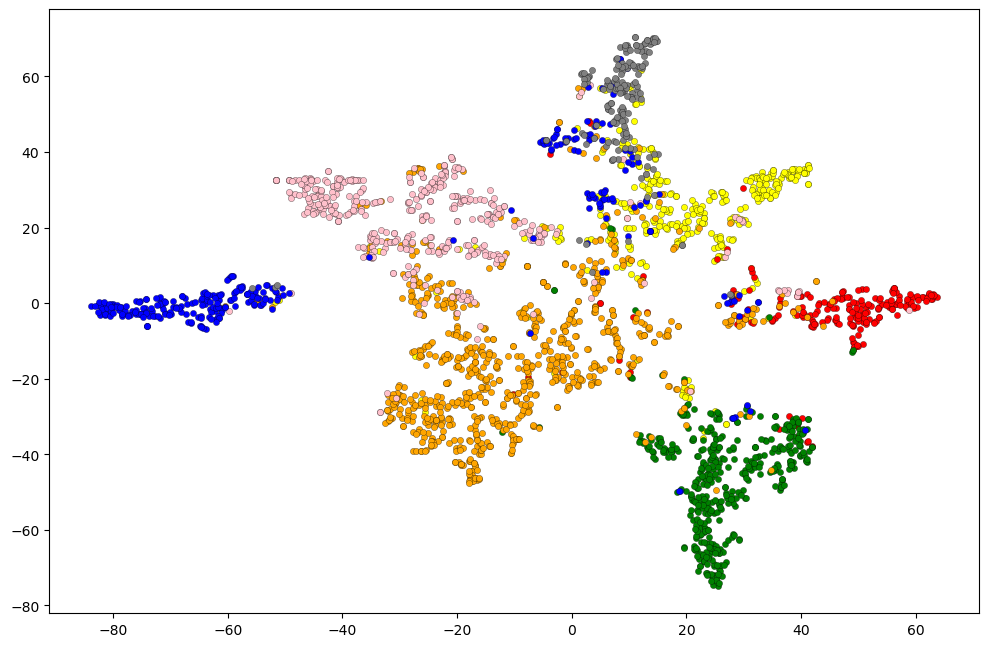

In [20]:
visualize(trainer_gat, visualization_type="tsne")

Sa grafika vidimo da je naš model odradio odličan posao - možemo jasno uočiti sedam klastera.

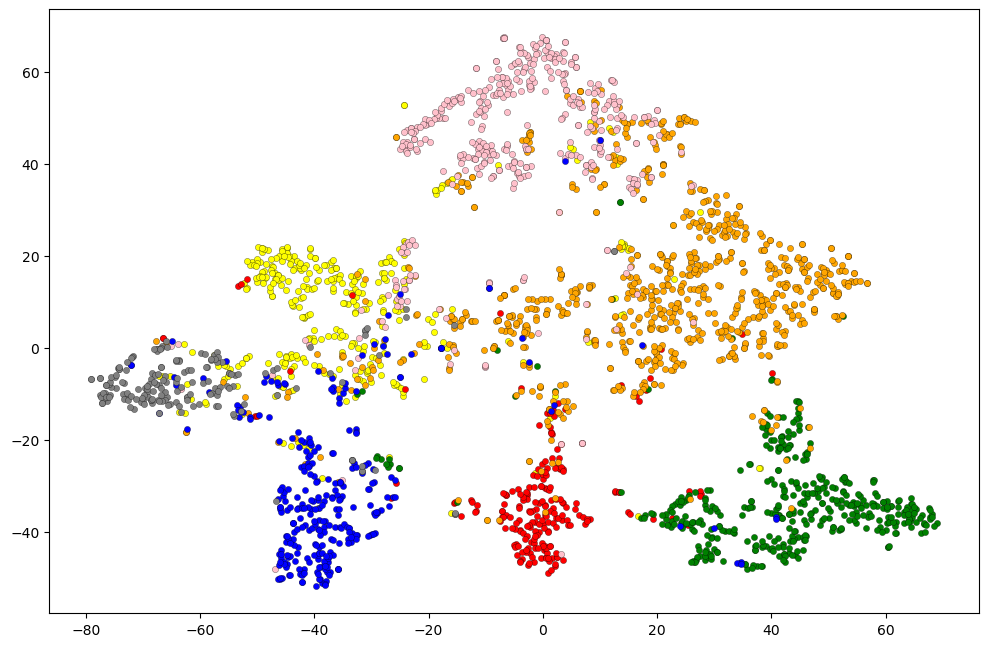

In [21]:
visualize(trainer_gcn, visualization_type="tsne")

Na grafiku za GCN model vidimo da su oblici i veličine klastera slični kao kod GAT modela.

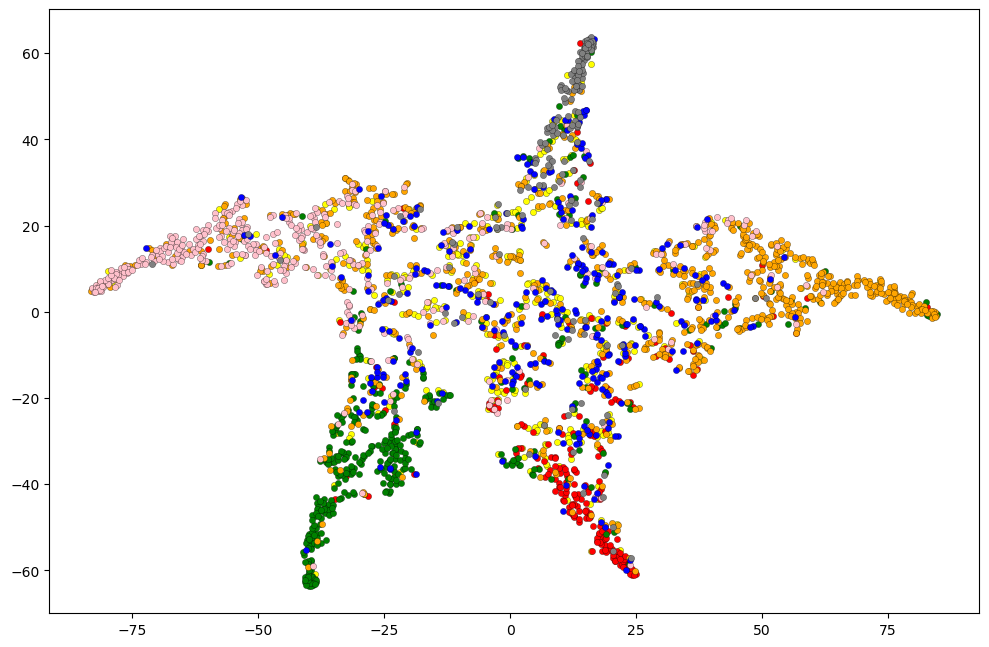

In [22]:
visualize(trainer_mlp, visualization_type="tsne")

Sa prethodnog grafika ne možemo jasno da uočimo različite klastere - to je očekivano zbog lošijih rezultata MLP modela.

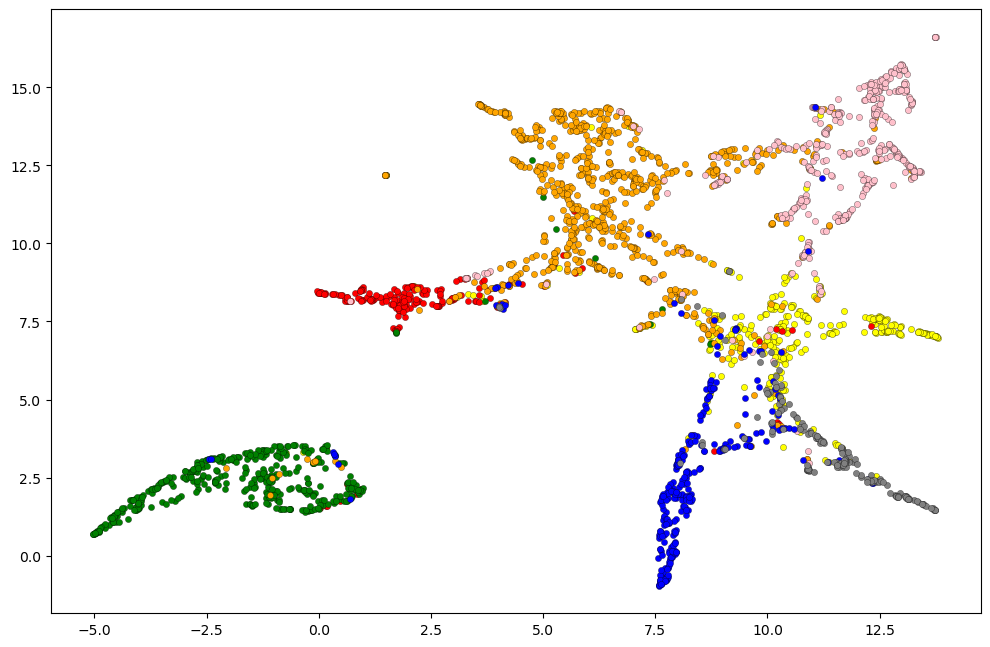

In [23]:
visualize(trainer_gat, visualization_type="umap")

Takođe jasno uočavamo sedam klastera. Rekli bismo da je UMAP u ovom konkretnom slučaju pogodniji za prikaz topologije podataka budući da su uočeni klasteri manjeg radijusa.

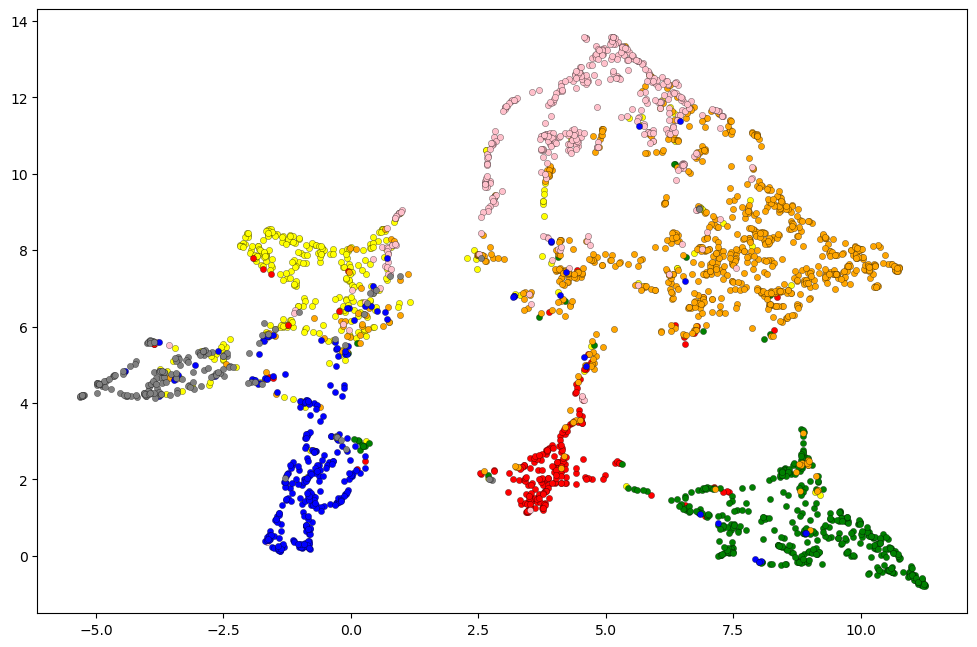

In [24]:
visualize(trainer_gcn, visualization_type="umap")

I sa ovog grafika jasno uočavamo 7 klastera.

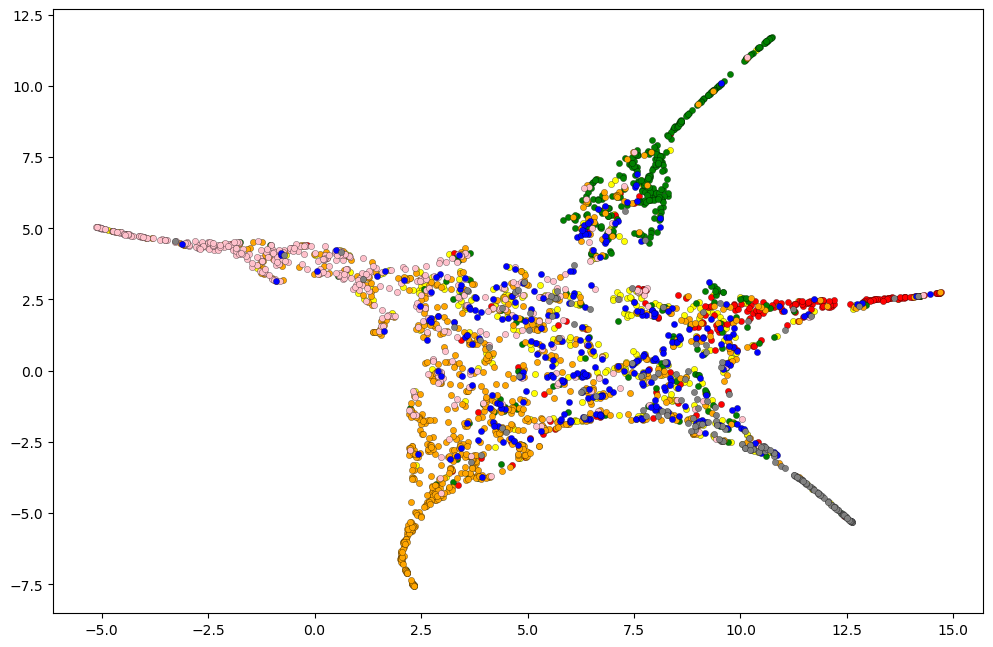

In [25]:
visualize(trainer_mlp, visualization_type="umap")

Kao i u TSNE grafiku, za MLP model ne vidimo jasnu razdvojenost po klasama.

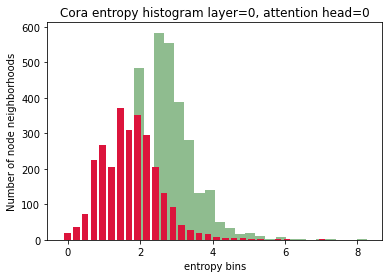

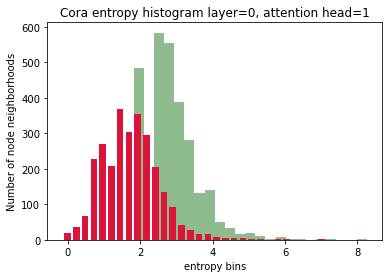

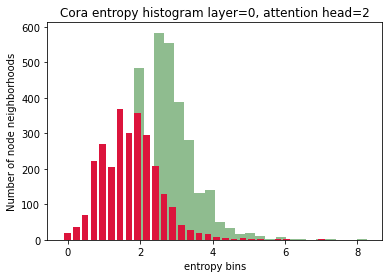

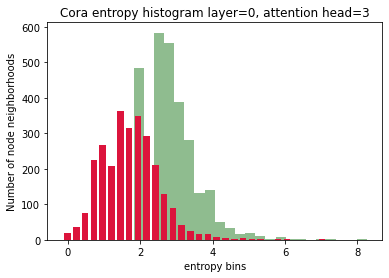

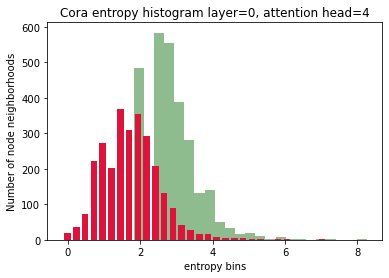

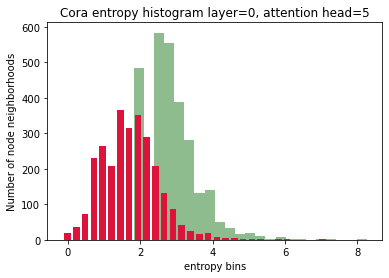

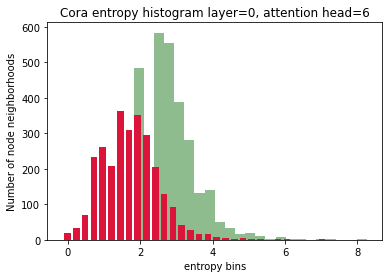

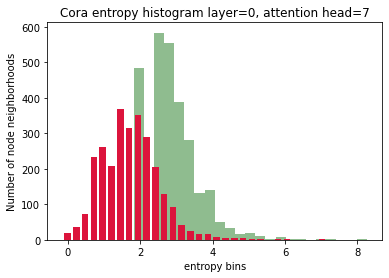

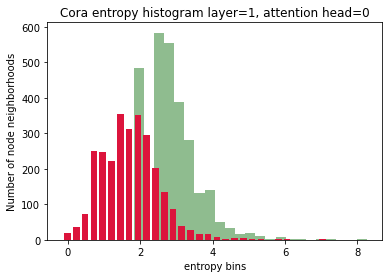

In [26]:
visualize(trainer_gat, visualization_type="entropy")

# Uticaj rezidualnih konekcija

Ispitaćemo uticaj rezidualnih konekcija u GAT arhitekturi. Istreniraćemo model sa istim hiperparametrima sa razlikom što su ovog puta rezidualne konekcije uključene. 

In [27]:
from copy import deepcopy

config_gat_skip = deepcopy(config_gat)
config_gat_skip["model_kwargs"]["add_skip_connection"] = True

trainer_gat_skip = Trainer(config_gat_skip)
trainer_gat_skip.run_training()

22-06-21 18:59:37: [INFO] epoch=[  1/200]: CE_train=1.94584 ACC_train=13.57%
22-06-21 18:59:40: [INFO] epoch=[  1/200]:   CE_val=1.94480   ACC_val=44.60%
22-06-21 18:59:42: [INFO] epoch=[  1/200]:  CE_test=1.94469  ACC_test=46.60%
22-06-21 18:59:43: [INFO] epoch=[  2/200]: CE_train=1.94407 ACC_train=33.57%
22-06-21 18:59:46: [INFO] epoch=[  3/200]: CE_train=1.94072 ACC_train=53.57%
22-06-21 18:59:50: [INFO] epoch=[  4/200]: CE_train=1.93669 ACC_train=65.71%
22-06-21 18:59:53: [INFO] epoch=[  5/200]: CE_train=1.93178 ACC_train=72.14%
22-06-21 18:59:55: [INFO] epoch=[  6/200]: CE_train=1.92308 ACC_train=79.29%
22-06-21 18:59:58: [INFO] epoch=[  7/200]: CE_train=1.91978 ACC_train=72.14%
22-06-21 19:00:00: [INFO] epoch=[  8/200]: CE_train=1.90857 ACC_train=82.86%
22-06-21 19:00:03: [INFO] epoch=[  9/200]: CE_train=1.89981 ACC_train=80.71%
22-06-21 19:00:06: [INFO] epoch=[ 10/200]: CE_train=1.89311 ACC_train=82.86%
22-06-21 19:00:08: [INFO] epoch=[ 10/200]:   CE_val=1.91430   ACC_val=71.20%

22-06-21 19:03:42: [INFO] epoch=[ 90/200]: CE_train=0.36414 ACC_train=92.14%
22-06-21 19:03:44: [INFO] epoch=[ 90/200]:   CE_val=0.91706   ACC_val=79.20%
22-06-21 19:03:45: [INFO] epoch=[ 90/200]:  CE_test=0.88230  ACC_test=80.80%
22-06-21 19:03:47: [INFO] epoch=[ 91/200]: CE_train=0.35587 ACC_train=92.86%
22-06-21 19:03:49: [INFO] epoch=[ 92/200]: CE_train=0.36426 ACC_train=91.43%
22-06-21 19:03:51: [INFO] epoch=[ 93/200]: CE_train=0.34839 ACC_train=92.86%
22-06-21 19:03:54: [INFO] epoch=[ 94/200]: CE_train=0.30459 ACC_train=96.43%
22-06-21 19:03:56: [INFO] epoch=[ 95/200]: CE_train=0.41874 ACC_train=90.71%
22-06-21 19:03:58: [INFO] epoch=[ 96/200]: CE_train=0.30889 ACC_train=95.00%
22-06-21 19:04:00: [INFO] epoch=[ 97/200]: CE_train=0.28726 ACC_train=95.71%
22-06-21 19:04:02: [INFO] epoch=[ 98/200]: CE_train=0.26832 ACC_train=98.57%
22-06-21 19:04:05: [INFO] epoch=[ 99/200]: CE_train=0.32073 ACC_train=95.71%
22-06-21 19:04:07: [INFO] epoch=[100/200]: CE_train=0.38426 ACC_train=95.00%

22-06-21 19:07:37: [INFO] epoch=[179/200]: CE_train=0.26430 ACC_train=96.43%
22-06-21 19:07:39: [INFO] epoch=[180/200]: CE_train=0.22969 ACC_train=97.86%
22-06-21 19:07:41: [INFO] epoch=[180/200]:   CE_val=0.84358   ACC_val=79.40%
22-06-21 19:07:42: [INFO] epoch=[180/200]:  CE_test=0.79684  ACC_test=80.10%
22-06-21 19:07:44: [INFO] epoch=[181/200]: CE_train=0.22644 ACC_train=97.14%
22-06-21 19:07:46: [INFO] epoch=[182/200]: CE_train=0.24048 ACC_train=97.14%
22-06-21 19:07:48: [INFO] epoch=[183/200]: CE_train=0.24534 ACC_train=97.86%
22-06-21 19:07:51: [INFO] epoch=[184/200]: CE_train=0.21484 ACC_train=97.14%
22-06-21 19:07:53: [INFO] epoch=[185/200]: CE_train=0.19701 ACC_train=97.86%
22-06-21 19:07:55: [INFO] epoch=[186/200]: CE_train=0.22389 ACC_train=96.43%
22-06-21 19:07:57: [INFO] epoch=[187/200]: CE_train=0.22470 ACC_train=97.86%
22-06-21 19:08:00: [INFO] epoch=[188/200]: CE_train=0.17585 ACC_train=98.57%
22-06-21 19:08:02: [INFO] epoch=[189/200]: CE_train=0.19024 ACC_train=100.00

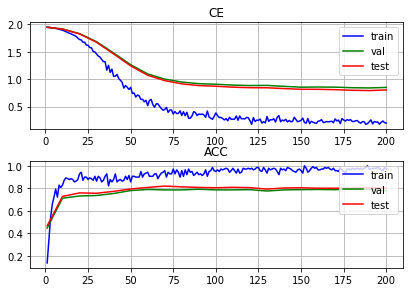

In [28]:
aggregator = trainer_gat_skip.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

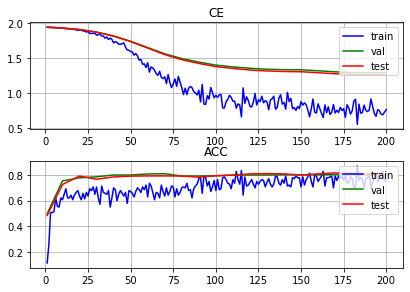

In [29]:
aggregator = trainer_gat.aggregator
fig, axes = plt.subplots(2)
fig.tight_layout()

# plotting loss
plot_metrics(aggregator, "CE", axes[0])
# plotting accuracy
plot_metrics(aggregator, "ACC", axes[1])

Primećujemo da su rezidualne konekcije smanjile šum funkcije gubitka u toku treninga, ali su doprinele i višem stepenu preprilagođenja.